In [1]:
import xarray as xr
import numpy as np
import dask
from dask.diagnostics import ProgressBar
import matplotlib.pylab as plt
import my_funs

from dask.distributed import Client, LocalCluster

# cluster = LocalCluster()
# client = Client(cluster)

# client = Client(processes=False)

dir = "/data/home/hamiddashti/hamid/nasa_above/greeness/"
out_dir = "/data/home/hamiddashti/hamid/nasa_above/greeness/working/"

lai_growing_trend_ds = xr.open_dataset(
    dir + "data/processed_data/noaa_nc/lai_fapar/trend/lai_growing_trend.nc"
)
lai_growing_trend = lai_growing_trend_ds["trend"]
lai_growing_trend_total = lai_growing_trend.where(
    lai_growing_trend_ds["h"] == 1
)  # where trend is sigificant


percent_cover = (
    xr.open_dataarray(dir + "data/processed_data/percent_cover/percent_cover.nc") * 100
)

# # There is a tiny difference between lat and lon of the dataset due to rounding
# # We make them equal
percent_cover["lat"] = lai_growing_trend_total["lat"]
percent_cover["lon"] = lai_growing_trend_total["lon"]
percent_cover = percent_cover.loc["1984":"2013"]
percent_cover = percent_cover.round(4)

# If a class is 0 change it no nan to prevent false zeros in diff later
percent_cover = percent_cover.where(percent_cover != 0)


Calculate natural variability 

In [8]:
def dist_matrix(x_size, y_size):
    import numpy as np

    a1 = np.floor(x_size / 2)
    a2 = np.floor(y_size / 2)
    x_arr, y_arr = np.mgrid[0:x_size, 0:y_size]
    cell = (a1, a2)
    dists = np.sqrt((x_arr - cell[0]) ** 2 + (y_arr - cell[1]) ** 2)
    dists[int(a1), int(a2)] = np.nan
    return dists

def estimate_lcc_trend(percent_cover, trend_total, thresh,winsize):
    win_size_half = int(np.floor(winsize / 2))
    dist_m = dist_matrix(winsize, winsize)

    lc_diff = percent_cover.diff("time")
    diff = (abs(lc_diff) > thresh) * 1
    changed_pixels = (diff == 1).any(dim=["time", "band"])

    trend_roll = (
        trend_total.rolling({"lat": winsize, "lon": winsize}, center=True)
        .construct({"lat": "lat_dim", "lon": "lon_dim"})
        .values
    )
    changed_pixels_roll = (
        changed_pixels.rolling({"lat": winsize, "lon": winsize}, center=True)
        .construct({"lat": "lat_dim", "lon": "lon_dim"})
        .values
    )
    percent_cover_roll = (
        percent_cover.rolling({"lat": winsize, "lon": winsize}, center=True)
        .construct({"lat": "lat_dim", "lon": "lon_dim"})
        .values
    )

    trend_nv = xr.full_like(trend_total, fill_value=np.nan, dtype=float)
    trend_eps = xr.full_like(trend_total, fill_value=np.nan, dtype=float)

    for i in range(0, changed_pixels.shape[0]):
        for j in range(0, changed_pixels.shape[1]):

            # Continue if central pixel not changed
            if changed_pixels_roll[i, j][win_size_half, win_size_half] == 0:
                continue

            mask = changed_pixels_roll[i, j]

            lc_stable = np.argwhere(mask == 0)

            trend_tmp = trend_roll[i, j]

            # if the central pixel trend is nan skip it
            if np.isnan(trend_tmp[win_size_half, win_size_half]):
                continue

            # print(trend_tmp[win_size_half, win_size_half])

            percent_cover_tmp = np.isfinite(
                percent_cover_roll[0, :, i, j, :, :]
            )  # shape (bands=10, winsize, winsize)
            center_lc = percent_cover_tmp[:, win_size_half, win_size_half]

            trend_tmp_masked = []
            dist_tmp_masked = []
            for m in range(len(lc_stable)):
                neighbor_lc = percent_cover_tmp[:, lc_stable[m][0], lc_stable[m][1]]
                if np.equal(center_lc, neighbor_lc).all():
                    trend_tmp_masked.append(trend_tmp[lc_stable[m][0], lc_stable[m][1]])
                    dist_tmp_masked.append(dist_m[lc_stable[m][0], lc_stable[m][1]])
            if len(trend_tmp_masked) == 0:
                continue

            trend_tmp_masked = np.array(trend_tmp_masked)
            dist_tmp_masked = np.array(dist_tmp_masked)
            tmp_var1 = np.nansum(trend_tmp_masked / dist_tmp_masked)
            trend_nv[i, j] = tmp_var1 / (np.nansum(dist_tmp_masked))
            trend_eps[i, j] = trend_tmp[win_size_half, win_size_half] - trend_nv[i, j]
    return trend_nv, trend_eps, changed_pixels


In [9]:
# Some setting
winsize = 7  # Window size to search for stable pixels around a central pixel
thresh = (
    10  # Threshold to consider a change in ladn cover happended over the past 30 years
)

lai_growing_trend_res, lai_growing_trend_lcc, changed_pixels = estimate_lcc_trend(
    percent_cover, lai_growing_trend_total, thresh, winsize
)

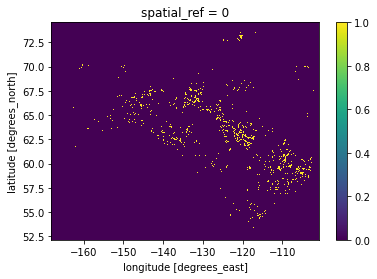

In [17]:
np.isfinite(changed_pixels.where(np.isfinite(lai_growing_trend_lcc))).plot()